Confirm that TripNet and TripModel generate sample results given the kernel. For both non-shifted tripnet and shifted tripnet

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from scipy import stats
from modelval import TripModel, network
from modelval.ArbDataGen import arb_w_gen
from modelval import TripNet
import time

% matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

In [3]:
# Load STDP data
vali_input_tt = np.load('/data/8ptl_vali_spk.npy')
vali_target_tt = np.load('/data/8ptl_vali_target.npy')
vali_ptl = np.load('/data/8ptl_vali_ptl.npy')

0.0115143308703 0.0104619495657 4.89306526525


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


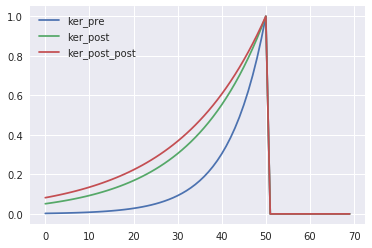

In [4]:
# Load Gerstner's kernel
# Visualize kernel
from modelval.kernel import KernelGen

para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = np.array(para[:4].values)
tau = np.array(para[4:].values)
reso_set = 2
ker_test = KernelGen()
ker_test.trip_model_ker(para, data_name='Hippocampus')

# Generate kernel for TripModel
ker_pre_post_hp, ker_post_pre_hp, ker_post_post_hp, len_ker = TripNet.ker_gen(a, tau, reso_set)
ker_test.kernel_pre = ker_pre_post_hp
ker_test.kernel_post = ker_post_pre_hp
ker_test.kernel_post_post = ker_post_post_hp
ker_test.kernel_scale = np.array([1,1,1])
ker_test.len_kernel = len_ker

plt.plot(ker_test.kernel_pre[150:220]/np.max(ker_test.kernel_pre), label='ker_pre')
plt.plot(ker_test.kernel_post[150:220]/np.max(ker_test.kernel_post), label='ker_post')
plt.plot(ker_test.kernel_post_post[150:220]/np.max(ker_test.kernel_post_post), label='ker_post_post')

plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2))

In [5]:
# Generate predcition with validation set from the augmented STDP data
STDP_vali_input = vali_input_tt[:int(vali_ptl[0]),:,:]
STDP_vali_target = vali_target_tt[:int(vali_ptl[0])]

In [6]:
# Generate prediction with Gerstner's model
loci_track_pre = []
loci_track_post = []
dt_track = []

for i in range(STDP_vali_input.shape[0]):
    loci_pre_STDP = np.where(STDP_vali_input[i,:,0] > 0)[0]
    loci_post_STDP = np.where(STDP_vali_input[i,:,1] > 0)[0]
    dt = np.mean(loci_post_STDP - loci_pre_STDP)
    dt_track.append(dt)
    
    loci_track_pre.append(loci_pre_STDP)
    loci_track_post.append(loci_post_STDP)
    
dt_final = np.hstack(dt_track)

In [7]:
start = time.time()
_, _, dw_AA_STDP = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre, loci_track_post, ifSTDP=1, reso = reso_set)
end = time.time()
print('{a} sec'.format(a=end-start))

8.787056684494019 sec


In [8]:
# Prediction with TripNet using TripModel parameter
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
spk_len = int(data[data['ptl_idx']==1]['train_len'].max() * 1000 / ker_test.reso_kernel)

# Build the TripNet
ground_truth_init = 1
toy_data_net2 = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=STDP_vali_input.shape[1])

In [9]:
# Predict
start = time.time()
_, TripNet_pred = arb_w_gen(spk_pairs=STDP_vali_input, spk_len=spk_len, kernel=ker_test, net_type='triplet')
end = time.time()
print('{a} sec'.format(a=end-start))

80.8962471485138 sec


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


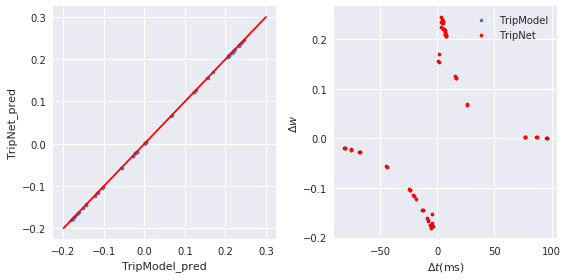

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(dw_AA_STDP, TripNet_pred, '.')
plt.plot(np.linspace(-0.2,0.3,10), np.linspace(-0.2,0.3,10), 'r')
plt.ylabel('TripNet_pred')
plt.xlabel('TripModel_pred')
plt.subplot(1,2,2)
plt.plot(dt_final * reso_set, dw_AA_STDP, '.', label='TripModel')
plt.plot(dt_final * reso_set, TripNet_pred, 'r.', label='TripNet')
plt.xlabel('$\Delta {t}$(ms)')
plt.ylabel('$\Delta {w}$')
plt.legend(loc='upper right')
plt.tight_layout()

In [11]:
Trip1_vali_input = vali_input_tt[int(vali_ptl[0]):int(vali_ptl[0])+int(vali_ptl[1]),:,:]
Trip1_vali_target = vali_target_tt[int(vali_ptl[0]):int(vali_ptl[0])+int(vali_ptl[1])]

Trip1_pre_spk = Trip1_vali_input[:,:,0]
Trip1_post_spk = Trip1_vali_input[:,:,1]

In [12]:
# Generate prediction with Gerstner's model
dt_mean2 = np.zeros(Trip1_vali_input.shape[0])
dt_track2 = []
loci_track_pre_trip1 = []
loci_track_post_trip1 = []
for i in range(Trip1_vali_input.shape[0]):
    loci_pre_trip1 = np.where(Trip1_vali_input[i,:,0] > 0)[0]
    loci_post_trip1 = np.where(Trip1_vali_input[i,:,1] > 0)[0]
    if len(loci_pre_trip1) > len(loci_post_trip1):  # Pre-post-pre
        dt2 = loci_pre_trip1[0::2] - loci_post_trip1
    else:
        dt2 = loci_pre_trip1 - loci_post_trip1[0::2]
    dt_track2.append(dt2)
    dt_mean2[i] = np.mean(dt2)
    loci_track_pre_trip1.append(loci_pre_trip1)
    loci_track_post_trip1.append(loci_post_trip1)
    
# dt_final_trip1 = np.hstack(dt_track_trip1)
para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
start = time.time()
w_AA_trip1, S_AA_trip1, dw_AA_trip1 = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre_trip1, loci_track_post_trip1, ifSTDP=0, reso = reso_set, tt_len = 500)
end = time.time()
print('{a} sec'.format(a=end-start))
diff = dw_AA_trip1  - np.hstack(Trip1_vali_target)
frac_var_tripmodel_trip1 = 1 - np.mean(diff** 2)/np.var(np.hstack(Trip1_vali_target))
slope, intercept, r_value_tripmodel_trip1, p_value, std_err = stats.linregress(np.hstack(Trip1_vali_target),np.squeeze(dw_AA_trip1))

8.162508964538574 sec


In [13]:
# Predict
start = time.time()
_, TripNet_pred_trip1 = arb_w_gen(spk_pairs=Trip1_vali_input, spk_len=spk_len, kernel=ker_test, net_type='triplet')
end = time.time()
print('{a} sec'.format(a=end-start))

0.8401720523834229 sec


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


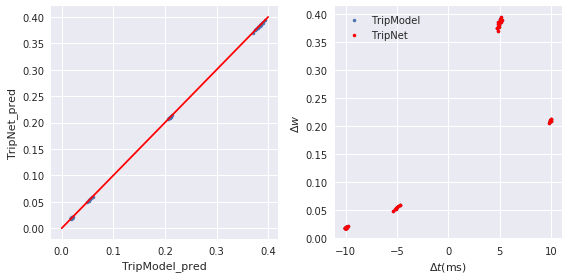

In [14]:
# Performance validation, TripModel and TripNet performs the same
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(dw_AA_trip1,TripNet_pred_trip1, '.')
plt.xlabel('TripModel_pred')
plt.ylabel('TripNet_pred')
plt.plot(np.linspace(0.0,0.4,10),np.linspace(0.0,0.4,10), 'r' )
plt.subplot(1,2,2)
plt.plot(dt_mean2*reso_set, dw_AA_trip1,'.', label='TripModel')
plt.plot(dt_mean2*reso_set, TripNet_pred_trip1,'r.', label='TripNet')
plt.legend(loc='upper left')
plt.xlabel('$\Delta {t}$(ms)')
plt.ylabel('$\Delta {w}$')
plt.tight_layout()

In [15]:
# Generate predcition with validation set from the augmented STDP data
Quad_vali_input = vali_input_tt[int(np.sum(vali_ptl[:2])):int(np.sum(vali_ptl[:3])),:,:]
Quad_vali_target = vali_target_tt[int(np.sum(vali_ptl[:2])):int(np.sum(vali_ptl[:3]))]

Quad_pre_spk = Quad_vali_input[:,:,0]
Quad_post_spk = Quad_vali_input[:,:,1]

In [16]:
# Generate prediction with Gerstner's model
dt_mean3 = np.zeros(Quad_vali_input.shape[0])
dt_track3 = []
loci_track_pre_quad = []
loci_track_post_quad = []
for i in range(Quad_vali_input.shape[0]):
    loci_pre_quad = np.where(Quad_vali_input[i,:,0] > 0)[0]
    loci_post_quad = np.where(Quad_vali_input[i,:,1] > 0)[0]
    if loci_pre_quad[0] < loci_post_quad[0]:   # Pre-post-post-pre
        dt3 = -loci_post_quad[1::2] + loci_pre_quad[0::2]
    else:
        dt3 = -loci_pre_quad[0::2] + loci_post_quad[1::2]
    dt_track3.append(dt3)
    dt_mean3[i] = np.mean(dt3)*reso_set
    loci_track_pre_quad.append(loci_pre_quad)
    loci_track_post_quad.append(loci_post_quad)

_, _, dw_AA_quad = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre_quad, loci_track_post_quad, ifSTDP=0, reso = reso_set, tt_len = 500)

In [17]:
# Predict
_, TripNet_pred_quad = arb_w_gen(spk_pairs=Quad_vali_input, spk_len=spk_len, kernel=ker_test, net_type='triplet')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


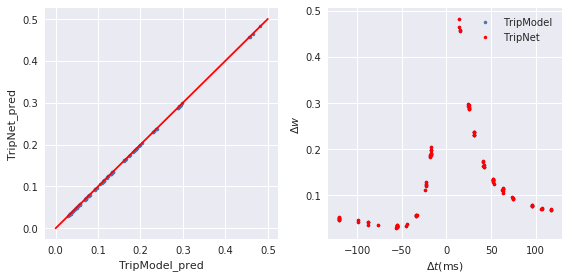

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(dw_AA_quad, TripNet_pred_quad, '.')
plt.plot(np.linspace(0.0,0.5,10), np.linspace(0.0,0.5,10), 'r')
plt.ylabel('TripNet_pred')
plt.xlabel('TripModel_pred')
plt.subplot(1,2,2)
plt.plot(dt_mean3, dw_AA_quad, '.', label='TripModel')
plt.plot(dt_mean3, TripNet_pred_quad, 'r.', label='TripNet')
plt.xlabel('$\Delta {t}$(ms)')
plt.ylabel('$\Delta {w}$')
plt.legend(loc='upper right')
plt.tight_layout()

0.0114889355013 0.0104374101286 5.49854674024


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


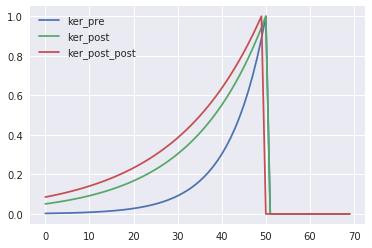

In [146]:
# Load Gerstner's kernel
# Visualize kernel
from modelval.kernel import KernelGen

para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = np.array(para[:4].values)
tau = np.array(para[4:].values)
reso_set = 2
ker_test = KernelGen()
ker_test.trip_model_ker(para, data_name='Hippocampus')

ker_pre_post_hp, ker_post_pre_hp, ker_post_post_hp, len_ker = TripNet.ker_gen_shift(a, tau, reso_set)
ker_test.kernel_pre = ker_pre_post_hp
ker_test.kernel_post = ker_post_pre_hp
ker_test.kernel_post_post = ker_post_post_hp
ker_test.kernel_scale = np.array([1,1,1])
ker_test.len_kernel = 401

plt.plot(ker_test.kernel_pre[150:220]/np.max(ker_test.kernel_pre), label='ker_pre')
plt.plot(ker_test.kernel_post[150:220]/np.max(ker_test.kernel_post), label='ker_post')
plt.plot(ker_test.kernel_post_post[150:220]/np.max(ker_test.kernel_post_post), label='ker_post_post')

plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2))

In [147]:
TripNet_pred_quad= TripNet.target_gen(data_train_pre=Quad_pre_spk, data_train_post=Quad_post_spk, kernel_pre_post=ker_pre_post_hp, kernel_post_pre=ker_post_pre_hp, kernel_post_post=ker_post_post_hp, len_ker=401)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


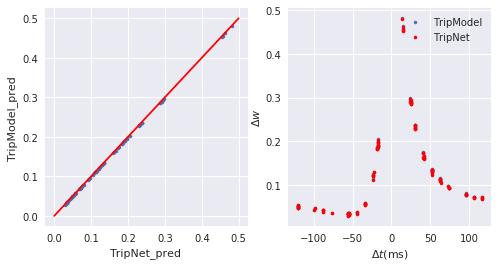

In [23]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(dw_AA_quad, TripNet_pred_quad[0], '.')
plt.plot(np.linspace(0.0,0.5,10), np.linspace(0.0,0.5,10), 'r')
plt.xlabel('TripNet_pred')
plt.ylabel('TripModel_pred')
plt.subplot(1,2,2)
plt.plot(dt_mean3, dw_AA_quad, '.', label='TripModel')
plt.plot(dt_mean3, TripNet_pred_quad[0], 'r.', label='TripNet')
plt.xlabel('$\Delta {t}$(ms)')
plt.ylabel('$\Delta {w}$')
plt.legend(loc='upper right')